# Fully-Connected Neural Nets

In this notebook we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
  
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import random 
import torch

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
file_id = "1mOerd6cQMKhOTmF5AoxQJ-RstCpirTM8"

# Download the data and code for fashion mnist
!pip install --upgrade --no-cache-dir gdown
!gdown --id "$file_id"
# unzip the download
!unzip "/content/hw-fcnet-fashion-mnist.zip"
import os
os.chdir('/content/hw-fcnet-fashion-mnist/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1mOerd6cQMKhOTmF5AoxQJ-RstCpirTM8
From (redirected): https://drive.google.com/uc?id=1mOerd6cQMKhOTmF5AoxQJ-RstCpirTM8&confirm=t&uuid=4badd312-cd7e-4fec-a8e0-7422531e81b6
To: /content/hw-fcnet-fashion-mnist.zip
100% 62.2M/62.2M [00:01<00:00, 45.0MB/s]
Archive:  /content/hw-fcnet-fashion-mnist.zip
   creating: hw-fcnet-fashion-mnist/
   creating: hw-fcnet-fashion-mnist/deeplearning/
   creating: hw-fcnet-fashion-mnist/deeplearning/build/
   creating: hw-fcnet-fashion-mnis

In [3]:
from deeplearning.data_utils import get_FMNIST_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.wrn_with_pen import WideResNet

seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the fashion MNIST data.

data = get_FMNIST_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 1, 28, 28)
y_train:  (49000,)
X_val:  (1000, 1, 28, 28)
y_val:  (1000,)
X_test:  (10000, 1, 28, 28)
y_test:  (10000,)


# Affine layer: forward
Implement the `affine_forward` function.

In [5]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################
    out = np.array([])
    for i in range(x.shape[0]):
        x_i = x[i, ...].reshape(1, -1)
        out = np.append(out, np.dot(x_i, w) + b)
    
    out = out.reshape(x.shape[0], b.shape[0])
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (x, w, b)
    return out, cache

Once you are done you can test your implementaion by running the following:

In [6]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769848308602077e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [7]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    #############################################################################
    # TODO: Implement the affine backward pass.                                 #
    #############################################################################
    dx = np.array([])
    for i in range(x.shape[0]):
        x_i = x[i, ...]
        x_i = x_i.reshape(1, -1)
        dx_i = np.dot(dout[i, ...], w.T)
        dx_i = dx_i.reshape(x_i.shape)
        dx = np.append(dx, dx_i)
    dx = dx.reshape(x.shape)
    dw = np.dot(x.reshape(x.shape[0], -1).T, dout)
    db = np.sum(dout, axis=0)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

In [8]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  2.0225828989929766e-09
dw error:  3.8196570037301105e-10
db error:  1.2710896071207802e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function.

In [9]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################
    out = np.maximum(0.0, x)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x
    return out, cache

Now test your implementation using the following:

In [10]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function. Note that the ReLU activation is not differentiable at 0, but typically we don't worry about this and simply assign either 0 or 1 as the derivative by convention.

In [11]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################
    dx = np.where(x >=0, dout, 0)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

Test your implementation using numeric gradient checking.

In [12]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756015284028938e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers for you.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [13]:
from deeplearning.fast_layers import *


def affine_relu_forward(x, w, b, dropout_param = {}):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    p = dropout_param.get("p", 0)
    if p > 0:
      p = dropout_param["p"]
      mask = (np.random.rand(*out.shape)> p) / (1-p)
      out *= mask

    cache = (fc_cache, relu_cache)


    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

run the following from the deeplearning directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [14]:
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  5.616798916325988e-10
dw error:  5.319021616402623e-10
db error:  4.97749028438748e-12


# Loss layer: Softmax
Here we provide SoftMax loss function that we will use to train our deep neural networks. You should understand how it works by looking at the implementation below.

You can make sure that the implementation is correct by running the following:

In [15]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
      for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    probs = np.exp(x - np.max(x, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = x.shape[0]
    loss = -np.sum(np.log(probs[np.arange(N), y])) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx

In [16]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302652998942053
dx error:  9.896204458881726e-09


# Two-layer network

Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. 

In [17]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3 * 32 * 32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - dropout: Scalar between 0 and 1 giving dropout strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian with standard deviation equal to   #
        # weight_scale, and biases should be initialized to zero. All weights and  #
        # biases should be stored in the dictionary self.params, with first layer  #
        # weights and biases using the keys 'W1' and 'b1' and second layer weights #
        # and biases using the keys 'W2' and 'b2'.                                 #
        ############################################################################
        self.params["W1"] = np.random.normal(loc =0, scale = weight_scale, size = (input_dim, hidden_dim))
        self.params["b1"] = np.zeros(hidden_dim)
        self.params["W2"] = np.random.normal(loc = 0, scale = weight_scale, size = (hidden_dim, num_classes))
        self.params["b2"] = np.zeros(num_classes)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        W1, b1, W2, b2 = self.params["W1"], self.params["b1"], self.params["W2"], self.params["b2"]
        N = X.shape[0]
        X = X.reshape(N, -1)

        h1, cache1 = affine_relu_forward(X, W1, b1)
        scores, cache2 = affine_forward(h1, W2, b2)
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization on the weights,    #
        # but not the biases.                                                      #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dx = softmax_loss(scores, y)
        dx, dw, db = affine_backward(dx, cache2)
        grads["W2"] = dw + self.reg * W2
        grads["b2"] = db 
        dx, grads["W1"], grads["b1"] = affine_relu_backward(dx, cache1)
        grads["W1"] += self.reg * W1
        loss += 0.5 * self.reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

Run the cell below to test your implementation.

In [18]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print ('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print ('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print ('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print ('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 4.04e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


# Solver
Following a modular design, for this assignment we have split the logic for training models into a separate class from the models themselves.

Open the cell below which contains a copy of the solver class and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [19]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various optoins (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists containing
    the accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'X_train': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and return
      a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data with the following:
          'X_train': Array of shape (N_train, d_1, ..., d_k) giving training images
          'X_val': Array of shape (N_val, d_1, ..., d_k) giving validation images
          'y_train': Array of shape (N_train,) giving labels for training images
          'y_val': Array of shape (N_val,) giving labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the learning
          rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val = data['X_val']
        self.y_val = data['y_val']

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in kwargs.keys())
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        self.update_rule = globals()[self.update_rule]

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config
        
            
    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay the
            # learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = (t == 0)
            last_it = (t == num_iterations + 1)
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(self.X_train, self.y_train,
                                                num_samples=1000)
                val_acc = self.check_accuracy(self.X_val, self.y_val)
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)

                if self.verbose:
                    print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                        self.epoch, self.num_epochs, train_acc, val_acc))

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

In [20]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
def sgd(w, dw, config=None):
  """
  Performs vanilla stochastic gradient descent.
  config format:
  - learning_rate: Scalar learning rate.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)

  w -= config['learning_rate'] * dw
  return w, config

model = TwoLayerNet(input_dim = 1*28*28)
solver = Solver(model, data)
solver.train()
best_model = solver.model
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.302577
(Epoch 0 / 10) train acc: 0.096000; val_acc: 0.086000
(Iteration 11 / 4900) loss: 2.302518
(Iteration 21 / 4900) loss: 2.302559
(Iteration 31 / 4900) loss: 2.302748
(Iteration 41 / 4900) loss: 2.302483
(Iteration 51 / 4900) loss: 2.302269
(Iteration 61 / 4900) loss: 2.302459
(Iteration 71 / 4900) loss: 2.302332
(Iteration 81 / 4900) loss: 2.302229
(Iteration 91 / 4900) loss: 2.302253
(Iteration 101 / 4900) loss: 2.302119
(Iteration 111 / 4900) loss: 2.301782
(Iteration 121 / 4900) loss: 2.301738
(Iteration 131 / 4900) loss: 2.301904
(Iteration 141 / 4900) loss: 2.301502
(Iteration 151 / 4900) loss: 2.301376
(Iteration 161 / 4900) loss: 2.301144
(Iteration 171 / 4900) loss: 2.300915
(Iteration 181 / 4900) loss: 2.300660
(Iteration 191 / 4900) loss: 2.299164
(Iteration 201 / 4900) loss: 2.299844
(Iteration 211 / 4900) loss: 2.297595
(Iteration 221 / 4900) loss: 2.298314
(Iteration 231 / 4900) loss: 2.296452
(Iteration 241 / 4900) loss: 2.293985
(Iterat

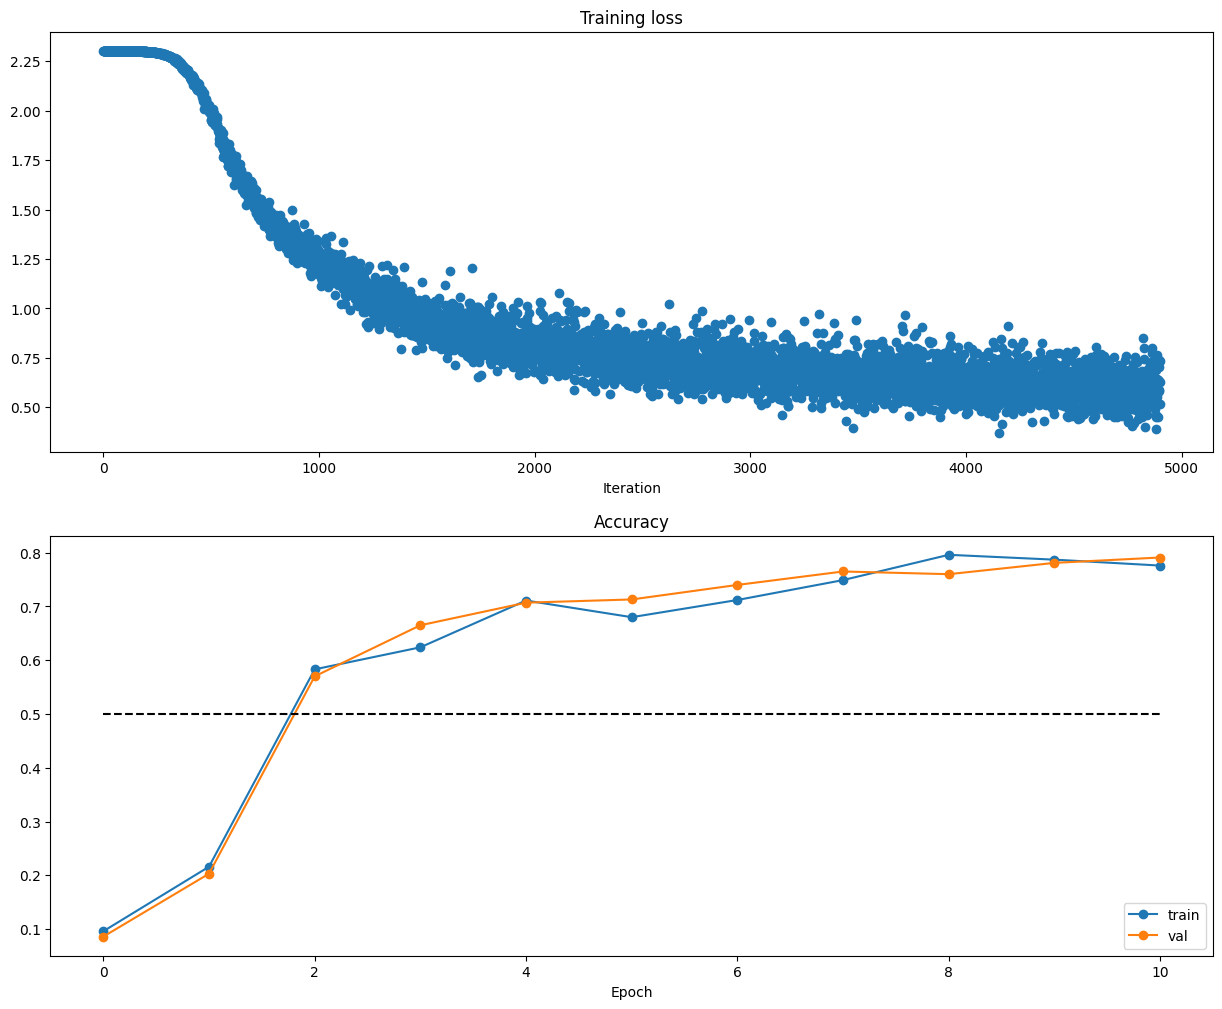

In [21]:
# Run this cell to visualize training loss and train / val accuracy, and save the log file of the
# experiment for submission.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization.

In [22]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=1 * 28 * 28, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
          the network should not use dropout at all.
        - use_batchnorm: Whether or not the network should use batch normalization.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.use_batchnorm = use_batchnorm
        self.use_dropout = dropout > 0
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution with standard deviation equal to  #
        # weight_scale and biases should be initialized to zero.                   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to one and shift      #
        # parameters should be initialized to zero.                                #
        ############################################################################
        for layer in range(self.num_layers-1):
                    w = np.random.normal(loc = 0, scale = weight_scale, size = (input_dim, hidden_dims[layer]))
                    b = np.zeros(hidden_dims[layer])
                    self.params["W" + str(layer+1)] = w
                    self.params["b" + str(layer+1)] = b

                    if self.use_batchnorm:
                        self.params["gamma" + str(layer+1)] = np.ones(hidden_dims[layer])
                        self.params["beta" + str(layer+1)] = np.zeros(hidden_dims[layer])

                    input_dim = hidden_dims[layer]
        
        w = np.random.normal(loc = 0, scale = weight_scale, size = (input_dim, num_classes))
        b = np.zeros(num_classes)
        self.params["W" + str(self.num_layers)] = w
        self.params["b" + str(self.num_layers)] = b
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {'mode': 'train', 'p': dropout}
            if seed is not None:
                self.dropout_param['seed'] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.use_batchnorm:
            self.bn_params = [{'mode': 'train'} for i in range(self.num_layers)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.dropout_param is not None:
            self.dropout_param['mode'] = mode
        if self.use_batchnorm:
            for bn_param in self.bn_params:
                bn_param[mode] = mode

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        cache = []
        dropout_param = self.dropout_param
        for layer in range(self.num_layers-1):
            W = self.params["W" + str(layer+1)]
            b = self.params["b" + str(layer+1)]

            X, cache_layer = affine_relu_forward(X, W, b, dropout_param = dropout_param)
            cache.append(cache_layer)
        
        W = self.params["W" + str(self.num_layers)]
        b = self.params["b" + str(self.num_layers)]
        scores, cache_layer = affine_forward(X, W, b)
        cache.append(cache_layer)     
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization on the         #
        # weights, but not the biases.                                             #
        #                                                                          #
        # When using batch normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dx = softmax_loss(scores, y)
        

        dx, dw, db = affine_backward(dx, cache[self.num_layers-1])
        loss += 0.5*self.reg*np.sum(self.params["W" + str(self.num_layers)]**2)
        grads["W" + str(self.num_layers)] = dw + self.reg*self.params["W" + str(self.num_layers)]
        grads["b" + str(self.num_layers)] = db       
        
        for layer in range(self.num_layers-2, -1, -1):
            loss += 0.5*self.reg*np.sum(self.params["W" + str(layer+1)]**2)
            dx, dw, db = affine_relu_backward(dx, cache[layer])
            grads["W" + str(layer+1)] = dw + self.reg*self.params["W" + str(layer+1)]
            grads["b" + str(layer+1)] = db
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [23]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.305562203077937
W1 relative error: 4.28e-06
W2 relative error: 3.20e-07
W3 relative error: 6.33e-08
b1 relative error: 5.78e-08
b2 relative error: 4.46e-09
b3 relative error: 1.23e-10
Running check with reg =  3.14
Initial loss:  6.948175015739591
W1 relative error: 2.12e-08
W2 relative error: 1.22e-07
W3 relative error: 2.71e-08
b1 relative error: 3.77e-08
b2 relative error: 1.37e-08
b3 relative error: 8.12e-11


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 103.370381
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.201000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.204000
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.263000
(Epoch 3 / 20) train acc: 0.620000; val_acc: 0.288000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.352000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.334000
(Iteration 11 / 40) loss: 7.324920
(Epoch 6 / 20) train acc: 0.700000; val_acc: 0.384000
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.355000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.390000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.412000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.401000
(Iteration 21 / 40) loss: 0.098444
(Epoch 11 / 20) train acc: 0.840000; val_acc: 0.373000
(Epoch 12 / 20) train acc: 0.920000; val_acc: 0.388000
(Epoch 13 / 20) train acc: 0.820000; val_acc: 0.411000
(Epoch 14 / 20) train acc: 0.880000; val_acc: 0.386000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.418000
(Iteration 31 / 40) loss

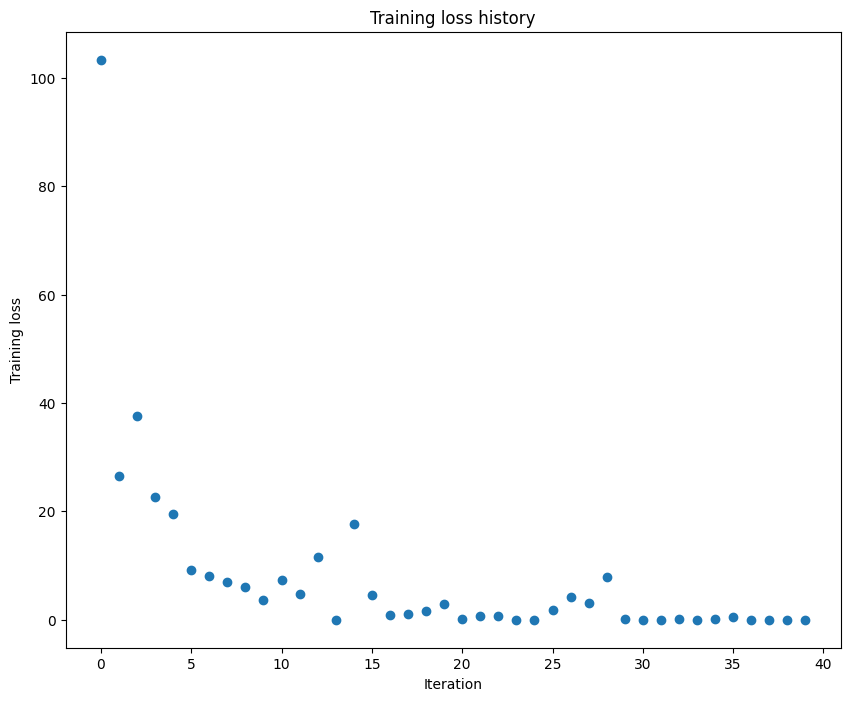

In [24]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
weight_scale = 0.5
learning_rate = 0.01
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 14.593140
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.072000
(Epoch 2 / 20) train acc: 0.180000; val_acc: 0.135000
(Epoch 3 / 20) train acc: 0.460000; val_acc: 0.282000
(Epoch 4 / 20) train acc: 0.500000; val_acc: 0.256000
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.295000
(Iteration 11 / 40) loss: 1.430462
(Epoch 6 / 20) train acc: 0.760000; val_acc: 0.334000
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.326000
(Epoch 8 / 20) train acc: 0.860000; val_acc: 0.335000
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.345000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.352000
(Iteration 21 / 40) loss: 0.621155
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.362000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.363000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.378000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.378000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.378000
(Iteration 31 / 40) loss:

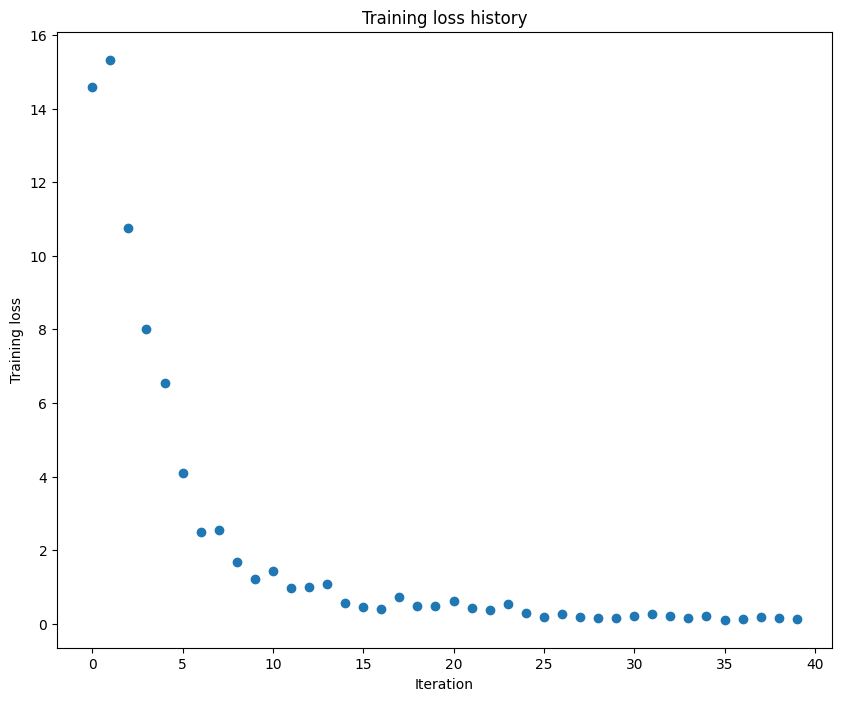

In [25]:
## TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
weight_scale = 0.2
learning_rate = 0.01
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:


It took me a longer time to find a weight scale and a learning rate that worked for the 5-layer net compared to the three-layer net. Also, I had to decreaes the weight scale otherwise the regularization term was overflowing (because the 5-layer network has a lot more parameters). 

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Read the following documentation to make sure you understand the API we set up for our optimizers. 

#### Optimizer API doc

We implemented various first-order update rules that are commonly used for
training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:

```python
def update(w, dw, config=None):
```

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning rate,
    momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

NOTE: For most update rules, the default learning rate will probably not perform
well; however the default values of the other hyperparameters should work well
for a variety of different problems.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.

Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [26]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a moving
      average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))

    next_w = None
    #############################################################################
    # TODO: Implement the momentum update formula as given in lecture. Store    #
    # the updated value in the next_w variable. You should also use and update  #
    # the velocity v.                                                           # 
    #############################################################################
    v = dw + config['momentum'] * v  
    
    next_w = w - config['learning_rate'] * v
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    config['velocity'] = v

    return next_w, config

In [27]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(0.5, 1.5, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-1, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
 [-0.504,      -0.45805263, -0.41210526, -0.36615789, -0.32021053],
 [-0.27426316, -0.22831579, -0.18236842, -0.13642105, -0.09047368],
 [-0.04452632,  0.00142105,  0.04736842,  0.09331579,  0.13926316],
 [ 0.18521053,  0.23115789,  0.27710526,  0.32305263,  0.369     ]])

expected_velocity = np.asarray([
 [1.04,       1.10684211, 1.17368421, 1.24052632, 1.30736842],
 [1.37421053, 1.44105263, 1.50789474, 1.57473684, 1.64157895],
 [1.70842105, 1.77526316, 1.84210526, 1.90894737, 1.97578947],
 [2.04263158, 2.10947368, 2.17631579, 2.24315789, 2.31      ]])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  9.259267785377383e-07
velocity error:  2.1398003469119033e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge a bit faster.

running with  sgd
(Iteration 1 / 200) loss: 2.302633
(Epoch 0 / 5) train acc: 0.122000; val_acc: 0.133000
(Iteration 11 / 200) loss: 2.302403
(Iteration 21 / 200) loss: 2.302172
(Iteration 31 / 200) loss: 2.302612
(Epoch 1 / 5) train acc: 0.115000; val_acc: 0.117000
(Iteration 41 / 200) loss: 2.302075
(Iteration 51 / 200) loss: 2.302265
(Iteration 61 / 200) loss: 2.301916
(Iteration 71 / 200) loss: 2.302625
(Epoch 2 / 5) train acc: 0.125000; val_acc: 0.132000
(Iteration 81 / 200) loss: 2.301951
(Iteration 91 / 200) loss: 2.301594
(Iteration 101 / 200) loss: 2.301873
(Iteration 111 / 200) loss: 2.302001
(Epoch 3 / 5) train acc: 0.108000; val_acc: 0.110000
(Iteration 121 / 200) loss: 2.301374
(Iteration 131 / 200) loss: 2.301879
(Iteration 141 / 200) loss: 2.301990
(Iteration 151 / 200) loss: 2.302266
(Epoch 4 / 5) train acc: 0.103000; val_acc: 0.110000
(Iteration 161 / 200) loss: 2.301982
(Iteration 171 / 200) loss: 2.300828
(Iteration 181 / 200) loss: 2.300857
(Iteration 191 / 200) los

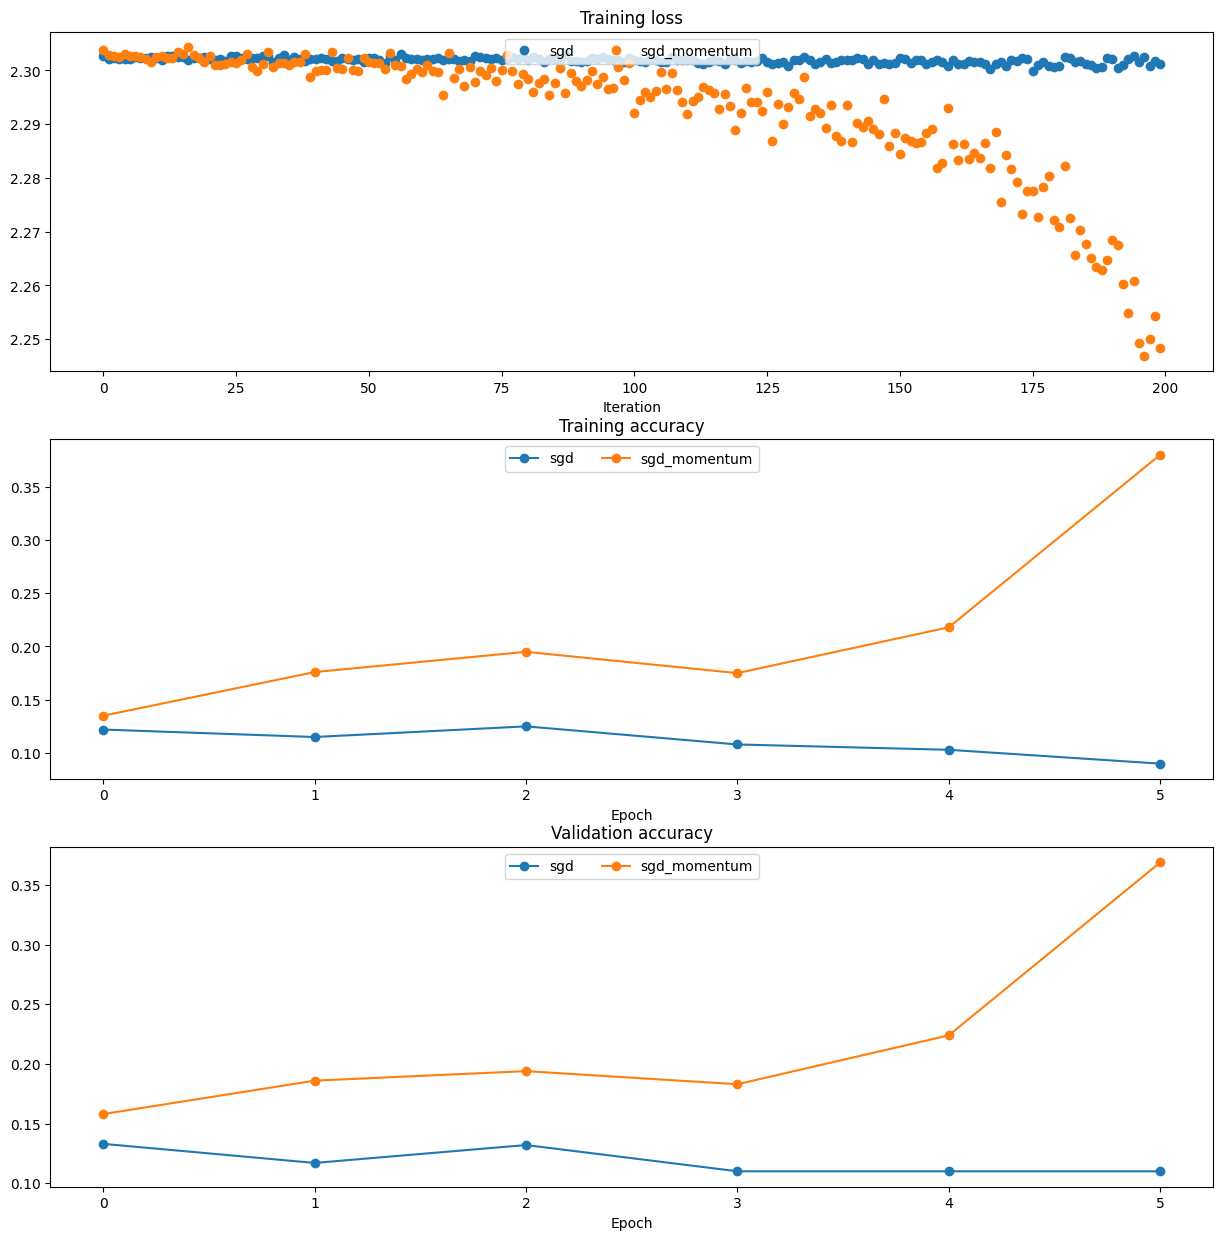

In [28]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Adam[1] is an update rule that set per-parameter learning rates by using a running average of the second moments of gradients.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

Implement the Adam update rule in the `adam` function, and check your implementation using the tests below.

In [29]:
def adam(x, dx, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(x))
    config.setdefault('v', np.zeros_like(x))
    config.setdefault('t', 0)

    next_x = None
    #############################################################################
    # TODO: Implement the Adam update formula, storing the next value of x in   #
    # the next_x variable. Don't forget to update the m, v, and t variables     #
    # stored in config and to use the epsilon scalar to avoid dividing by zero. #
    #############################################################################
    t = config["t"] + 1
    g = dx
    m = config["beta1"] * config["m"] + (1 - config["beta1"]) * g
    v = config["beta2"] * config["v"] + (1 - config["beta2"]) * g**2
    m_hat = m / (1 - config["beta1"]**(t))
    v_hat = v / (1 - config["beta2"]**(t))
    next_x = x - config["learning_rate"] * m_hat / (np.sqrt(v_hat) + config["epsilon"])  
    config["m"] = m
    config["v"] = v
    config["t"] = t
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

    return next_x, config

In [30]:
# Test Adam implementation; you should see errors around 1e-7 or less

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])
expected_t = 6

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('v error: ', rel_error(expected_v, config['v']))
print ('m error: ', rel_error(expected_m, config['m']))
print ('t error: ', rel_error(expected_t, config['t']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09
t error:  0.0


# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable and the solver used in the `best_solver` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so.

In [31]:
# get CIFAR-10 data
import tensorflow as tf
import tensorflow_datasets as tfds

data = tfds.load('cifar10', split='train+test', shuffle_files=True, as_supervised=True)

# split data into train and test
train_data = data.take(40000)
val_data = data.skip(40000).take(10000)
test_data = data.skip(50000)

# convert to numpy arrays
train_data = tfds.as_numpy(train_data)
val_data = tfds.as_numpy(val_data)
test_data = tfds.as_numpy(test_data)

# get the data and labels
X_train = np.array([x[0] for x in train_data])
y_train = np.array([x[1] for x in train_data])

X_test = np.array([x[0] for x in test_data])
y_test = np.array([x[1] for x in test_data])

X_val = np.array([x[0] for x in val_data])
y_val = np.array([x[1] for x in val_data])

# Create a dictionary with the data and labels
data = {
      'X_train': X_train, # training data
      'y_train': y_train, # training labels
      'X_val': X_val, # validation data
      'y_val': y_val, # validation labels
      "X_test": X_test,
      'y_test': y_test
    }

for k, v in data.items():
    print('%s: ' % k, v.shape)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteUJZDE8/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteUJZDE8/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
X_train:  (40000, 32, 32, 3)
y_train:  (40000,)
X_val:  (10000, 32, 32, 3)
y_val:  (10000,)
X_test:  (10000, 32, 32, 3)
y_test:  (10000,)


In [ ]:
best_model = None
best_solver = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch normalization and dropout useful. Store your best model in the    #
# best_model variable and the solver used to train it in the best_solver       #
# variable.                                                                    #
################################################################################
model = FullyConnectedNet([1024*512*256], input_dim=32*32*3, weight_scale=5e-2, dropout = 0.3)
best_solver = solver = Solver(model, data,
              num_epochs=20, batch_size=100,
              update_rule="adam",
              optim_config={
                'learning_rate': 1e-3, 
              },
              verbose=True)
best_solver.train()
best_model = best_solver.model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test your model
Run your best model on the validation and test sets and record the training logs of the best solver. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
val_acc = (y_val_pred == data['y_val']).mean()
test_acc = (y_test_pred == data['y_test']).mean()
print ('Validation set accuracy: ', val_acc)
print ('Test set accuracy: ', test_acc)